# ĐỒ ÁN CUỐI KỲ: Phân tích tỉ lệ rời bỏ của khách hàng trong BankChurners Dataset
Môn học: CSC17104 – Lập trình cho Khoa học Dữ liệu

Khoa: Công nghệ Thông tin - ĐH KHTN, ĐHQG-HCM

Nhóm 26:
Sinh viên thực hiện:
- 23122035 - Châu Văn Minh Khoa
- 23122046 - Phan Ngọc Quân 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

##### Chuẩn bị lại dữ liệu từ file trước

In [2]:
data_path = "data/BankChurners.csv"
df = pd.read_csv(data_path)
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [3]:
df = df.drop(columns=['CLIENTNUM'])
df = df.drop(columns=df.columns[-2:])

In [4]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
numerical_cols

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [5]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols

Index(['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category'],
      dtype='object')

## IV. QUESTION FORMULATION

| The Question | Motivation | Benefits & Real-world Decision |
|---|---|---|
| **1. Có phải nhóm khách hàng Rời đi có xu hướng phân bố ở hai thái cực không? Một phần là những người sử dụng quá ít và một phần là những người sử dụng quá mức?** | **Why:** Nhóm muốn kiểm tra xem yếu tố sử dụng thể là một feature tốt để dự đoán khách hàng rời đi hay không. Ví dụ khách hàng sử dụng quá ít dịch vụ cho thấy sự thờ ơ; khách hàng sử dụng quá mức có thể tìm kiếm sản phẩm chuyên biệt ở nơi khác.<br>**Who:** Bộ phận Quản lý quan hệ khách hàng, Phân tích dữ liệu, và Kinh doanh/Tiếp thị. | **Insights:** Phần thái cực "sử dụng quá mức" có thể là dấu hiệu họ đang chuyển dòng tiền hoặc chuyển hoạt động giao dịch chính sang ngân hàng khác. Phần thái cực "sử dụng quá ít" có thể là do họ cảm thấy thẻ không cần thiết nữa và bỏ đi.<br>**Decision:** Can thiệp bằng các ưu đãi tăng cường giá trị/khuyến khích sử dụng.|
| **2. Liệu nhóm khách hàng có thu nhập cao nhưng trình độ học vấn thấp có xu hướng "vung tay quá trán" và duy trì dư nợ quay vòng (`Total_Revolving_Bal`) cao hơn nhóm có học vấn cao không?** | **Why:** Nhóm em muốn kiểm chứng xem liệu trình độ học vấn có ảnh hưởng gì đến việc quản lý tài chính không. Ví dụ như người học vấn thấp sẽ tiêu xài hoang phí, người học vấn cao sẽ chi tiêu hợp lý.<br>**Who:** Bộ phận Phân tích dữ liệu, Marketing và Quản lý danh mục khách hàng. | **Insights:** Xác định được nhóm khách hàng nào “nhạy cảm” hơn với nợ quay vòng. Điều này phản ánh sự khác biệt về khả năng chịu đựng nợ và ưu tiên tài chính giữa các nhóm hộ gia đình.<br>**Decision:** Thiết kế các chiến lược giữ chân theo phân khúc: với nhóm gia đình lớn, ưu tiên các chương trình **giảm lãi, trả góp linh hoạt, hoặc tư vấn quản lý nợ** khi số dư quay vòng tăng; với nhóm độc thân, tập trung vào **ưu đãi trải nghiệm, hoàn tiền và phần thưởng** thay vì can thiệp tài chính sớm.
| **3. Có mối tương quan nào giữa tuổi khách hàng (`Customer_Age`), thời gian sử dụng thẻ (`Months_on_book`) và tỷ lệ churn không?** | **Why:** Tuổi và thời gian sử dụng thẻ phản ánh mức độ gắn kết và giai đoạn cuộc sống của khách hàng. Khách trẻ thường linh hoạt, dễ rời bỏ do thay đổi công việc hoặc nhu cầu, trong khi khách lâu năm có thể rời bỏ vì sản phẩm không còn phù hợp.<br>**Who:** Bộ phận Giữ chân khách hàng và Phát triển sản phẩm . | **Insights:** Phát hiện sự khác biệt. Khách hàng lâu năm có thể có xu hướng churn khi họ nhu cầu tăng nhưng quyền lợi không đổi; nhóm khách trẻ có độ trung thành thấp, dễ bị thu hút bởi ưu đãi ngắn hạn từ đối thủ.<br>**Decision:** Không giả định khách lâu năm là an toàn; cá nhân hóa sản phẩm theo độ tuổi và vòng đời khách hàng, đồng thời xây dựng chương trình gắn kết sớm cho khách hàng trẻ. |
| **4. Liệu có phải nhóm khách hàng có hạn mức tín dụng cao (`Credit_Limit`) nhưng mức độ sử dụng thấp (`Utilization`) là nhóm có nguy cơ rời bỏ ngầm cao nhất?** | **Why:** Ngân hàng thường tập trung vào những người quản lý rủi ro nợ xấu (xài quá hạn mức), nhưng lại bỏ quên nhóm người "thờ ơ" (có thẻ nhưng không dùng).<br>**Who:** Bộ phận Quản trị rủi ro và Phát triển kinh doanh. | **Insights:** Phân biệt được đâu là khách hàng trung thành, đâu là khách hàng "ngủ đông" đang dùng thẻ của đối thủ cạnh tranh.<br>**Decision:** Thay vì tăng hạn mức, ngân hàng cần tung ra các chương trình khuyến khích chi tiêu (Cashback, Rewards) dành riêng cho nhóm VIP đang "đóng băng" này. |
| **5. Các chỉ số tương tác (`Contacts_Count`, `Months_Inactive`) và giao dịch trong 12 tháng qua (`Total_Trans_Amt`) có mối quan hệ thế nào với quyết định rời bỏ?** | **Why:** Đây là các biến hành vi (Behavioral) phản ánh trực tiếp sự hài lòng (qua số lần phàn nàn) và sự gắn kết (qua tần suất giao dịch).<br>**Who:** Bộ phận Dịch vụ khách hàng (Customer Service). | **Insights:** Tìm ra "Ngưỡng chịu đựng" (Threshold). Ví dụ: Khách hàng liên hệ quá 4 lần/năm

## V. DATA ANALYSIS

Tiền xử lí và phân tích dữ liệu để đưa ra trả lời cho từng câu hỏi 

#### **1. Có phải nhóm khách hàng Rời đi có xu hướng phân bố ở hai thái cực không? Một phần là những người sử dụng quá ít và một phần là những người sử dụng quá mức?**

### A. Tiền xử lý

1. Kiểm tra và chuẩn hóa kiểu dữ liệu của 3 cột `Avg_Utilization_Ratio` và `Attrition_Flag`
- `Avg_Utilization_Ratio`: kiểm tra xem dữ liệu ở dạng số nguyên hay chưa
- `Attrition_Flag`: kiểm tra xem đã ở dạng nhị phân 0/1 hay chưa

Mục đích: dễ phân tích, dễ tính tỷ lệ và mô hình hóa.

2. Kiểm tra và xử lý missing values
 - Kiểm tra cột `Avg_Utilization_Ratio` nếu tồn tại missing_values thì xử lý bằng cách điền giá trị thiếu bằng mean.
 - Đối với cột 'Attrition_Flag`: vì đây là cột mục tiêu(target) nên đảm bảo không chứa missing values

Mục đích: dễ phân tích, tăng độ chính xác

3. Kiểm tra và xử lý giá trị ngoại lai
- Sử dụng phương pháp IQR để xác định và loại bỏ giá trị ngoại lai

Mục đích: Chúng ta cần kiểm tra xem có giá trị nào quá vô lý (ví dụ: vô cực hoặc quá lớn do chia cho số gần 0) để xử lý hoặc ghi nhận

In [6]:
df1 = df.copy()

# 1. Chuyển đổi Biến Mục tiêu (Attrition_Flag) về dạng nhị phân (0, 1)
if df1['Attrition_Flag'].dtype == 'object':
    df1['Attrition_Flag'] = np.where(df1['Attrition_Flag'] == 'Attrited Customer', 1, 0)
    print("Đã chuyển đổi 'Attrition_Flag' về 0/1.")

# 2. Chuẩn hóa kiểu dữ liệu về float64 cho các biến liên tục
float_cols = ['Avg_Utilization_Ratio']
for col in float_cols:
    if df1[col].dtype != 'float64':
        df1[col] = df1[col].astype('float64')
    print(f"Đã chuẩn hóa kiểu dữ liệu cho '{col}'.")

# 3. Xử lý Giá trị Missing Values bằng mean
for col in float_cols:
    if df1[col].isna().sum() > 0:
        mean_val = df1[col].mean()
        df1[col] = df1[col].fillna(mean_val)
        print(f"Đã xử lý {df1[col].isna().sum()} giá trị thiếu của '{col}' bằng trung bình.")


# 4. Xử lý Giá trị Outliers bằng phương pháp IQR
def remove_outliers_iqr(df, col):
    s = df[col]
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    
    # Giới hạn giá trị trong khoảng [lower, upper]
    df = df[(s >= lower) & (s <= upper)]
    return df

rows_before_outlier_removal = df1.shape[0]

df1 = remove_outliers_iqr(df1, 'Avg_Utilization_Ratio')

rows_after_outlier_removal = df1.shape[0]
print(f"\nSố lượng dòng trước khi xử lý ngoại lai: {rows_before_outlier_removal}")
print(f"Số lượng dòng sau khi xử lý ngoại lai: {rows_after_outlier_removal}")
print(f"Số dòng bị loại bỏ: {rows_before_outlier_removal - rows_after_outlier_removal}")

# Kiểm tra lại Avg_Utilization_Ratio để đảm bảo không bị ảnh hưởng bởi việc loại bỏ quá nhiều
print(f"Kiểm tra lại dữ liệu sau xử lý: {df1[['Attrition_Flag', 'Avg_Utilization_Ratio']].head()}")

Đã chuyển đổi 'Attrition_Flag' về 0/1.
Đã chuẩn hóa kiểu dữ liệu cho 'Avg_Utilization_Ratio'.

Số lượng dòng trước khi xử lý ngoại lai: 10127
Số lượng dòng sau khi xử lý ngoại lai: 10127
Số dòng bị loại bỏ: 0
Kiểm tra lại dữ liệu sau xử lý:    Attrition_Flag  Avg_Utilization_Ratio
0               0                  0.061
1               0                  0.105
2               0                  0.000
3               0                  0.760
4               0                  0.000


### B. Phân tích

Phân tích Tỷ lệ trong các Phân khúc Sử dụng
- Mục tiêu: Kiểm tra rằng tỷ lệ Rời đi cao hơn ở hai thái cực hay không.
- Thực hiện:Tạo các phân khúc sử dụng: 
    - Chia Avg_Utilization_Ratio thành các bin (khoảng) kinh doanh có ý nghĩa, ví dụ:Low Use (Sử dụng Thấp, Rủi ro thẻ không cần thiết), Optimal Use (Sử dụng Tối ưu), High Use (Sử dụng Cao, Rủi ro áp lực nợ)
    - Tính toán Tỷ lệ Rời đi (Attrition Rate) trong từng phân khúc.
    - Kiểm tra kết quả

In [7]:
# Xác định các ranh giới cho phân khúc
bins = [0.0, 0.1, 0.7, 1.0] # các ranh giới phân khúc là tự đặt, có thể điều chỉnh
# Tên các phân khúc tương ứng
labels = ['Low Use', 'Optimal Use', 'High Use'] 

# Tạo biến phân khúc mới
df1['Utilization_Segment'] = pd.cut(
    df1['Avg_Utilization_Ratio'],
    bins=bins,
    labels=labels,
    right=False, 
    include_lowest=True
)

print("Kiểm tra số lượng khách hàng trong mỗi phân khúc:")
print(df1['Utilization_Segment'].value_counts())

# Tính toán tổng số lượng và số lượng khách hàng rời đi cho mỗi phân khúc
churn_by_segment = df1.groupby('Utilization_Segment', observed=True)['Attrition_Flag'].agg(['count', 'sum'])
churn_by_segment.columns = ['Total_Customers', 'Churned_Customers']

# Tính toán Tỷ lệ Rời đi trong mỗi phân khúc
churn_by_segment['Attrition_Rate'] = (
    churn_by_segment['Churned_Customers'] / churn_by_segment['Total_Customers']
)

print("\nTỷ lệ Rời đi theo Phân khúc Sử dụng:")
churn_analysis = churn_by_segment.sort_values(by='Attrition_Rate', ascending=False)
churn_analysis['Attrition_Rate'] = (churn_analysis['Attrition_Rate'] * 100).round(2).astype(str) + '%'
print(churn_analysis)

Kiểm tra số lượng khách hàng trong mỗi phân khúc:
Utilization_Segment
Optimal Use    5034
Low Use        4030
High Use       1063
Name: count, dtype: int64

Tỷ lệ Rời đi theo Phân khúc Sử dụng:
                     Total_Customers  Churned_Customers Attrition_Rate
Utilization_Segment                                                   
Low Use                         4030               1068          26.5%
High Use                        1063                137         12.89%
Optimal Use                     5034                422          8.38%


### C. Trực quan hóa

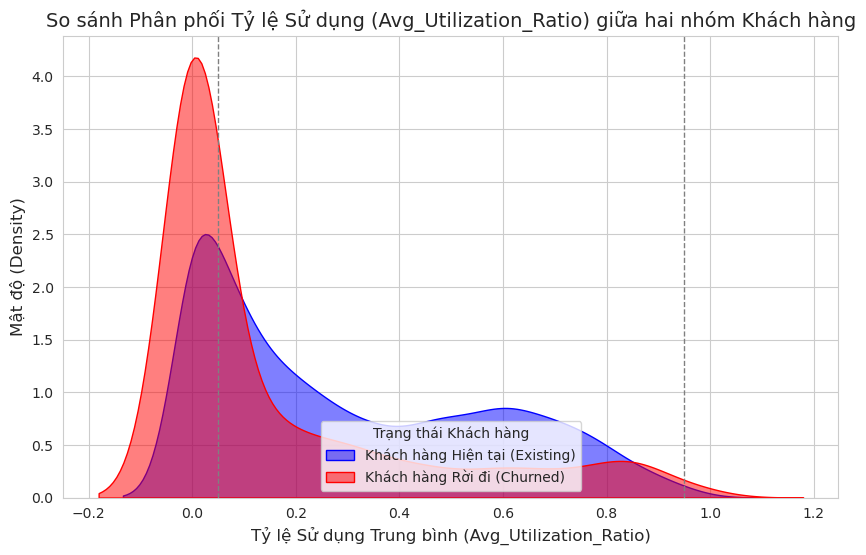

In [8]:
# Thiết lập kiểu hiển thị cho biểu đồ
sns.set_style("whitegrid")

# Tạo biểu đồ phân phối mật độ (KDE Plot)
plt.figure(figsize=(10, 6))

# Vẽ KDE Plot cho nhóm Khách hàng Hiện tại (Attrition_Flag == 0)
sns.kdeplot(
    df1[df1['Attrition_Flag'] == 0]['Avg_Utilization_Ratio'],
    label='Khách hàng Hiện tại (Existing)',
    color='blue',
    fill=True,
    alpha=0.5
)

# Vẽ KDE Plot cho nhóm Khách hàng Rời đi (Attrition_Flag == 1)
sns.kdeplot(
    df1[df1['Attrition_Flag'] == 1]['Avg_Utilization_Ratio'],
    label='Khách hàng Rời đi (Churned)',
    color='red',
    fill=True,
    alpha=0.5
)

# Thêm tiêu đề và nhãn
plt.title('So sánh Phân phối Tỷ lệ Sử dụng (Avg_Utilization_Ratio) giữa hai nhóm Khách hàng', fontsize=14)
plt.xlabel('Tỷ lệ Sử dụng Trung bình (Avg_Utilization_Ratio)', fontsize=12)
plt.ylabel('Mật độ (Density)', fontsize=12)
plt.legend(title='Trạng thái Khách hàng')

# Vẽ đường tham chiếu tại các điểm cực (0.0 và 1.0)
plt.axvline(x=0.05, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=0.95, color='gray', linestyle='--', linewidth=1)

# Hiển thị biểu đồ
plt.show()

/tmp/ipykernel_1237/3424284146.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


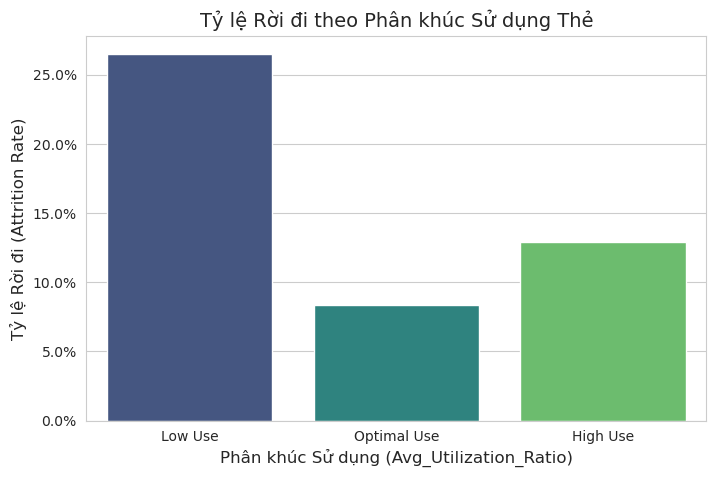

In [9]:
# Trực quan hóa kết quả 
plt.figure(figsize=(8, 5))
sns.barplot(
    x=churn_analysis.index, 
    y=churn_analysis['Churned_Customers'] / churn_analysis['Total_Customers'],
    palette='viridis'
)
plt.title('Tỷ lệ Rời đi theo Phân khúc Sử dụng Thẻ', fontsize=14)
plt.xlabel('Phân khúc Sử dụng (Avg_Utilization_Ratio)', fontsize=12)
plt.ylabel('Tỷ lệ Rời đi (Attrition Rate)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.show() 

- Trả lời câu hỏi: Dựa vào hình vẽ và phân tích ở trên, ta thấy nhóm khách hàng Rời đi có xu hướng phân bố ở hai thái cực về Tỷ lệ Sử dụng Trung bình (Avg_Utilization_Ratio). Mối quan hệ giữa tỷ lệ sử dụng thẻ và nguy cơ rời đi không tuyến tính, mà tuân theo dạng chữ U.
    - Nhóm rủi ro cao nhất về cả Tỷ lệ và Khối lượng là Low Use: Nhóm này có tỷ lệ Rời đi cao gấp 3 lần nhóm Optimal Use. (26.5% so với 8.38%)
    - Nhóm rủi ro cao, khối lượng thấp là High Use: Nhóm này có tỷ lệ Rời đi cao hơn gần 1.5 lần nhóm Optimal Use (12.89% so với 8.38%).

- Giải pháp thực tiễn: 
    - Ưu tiên cho nhóm Low Use: Tỷ lệ Rời đi cao cho thấy khách hàng cảm thấy thẻ không mang lại giá trị thực tế hoặc không cần thiết. Do đó ngân hàng cần can thiệp bằng các ưu đãi tăng cường giá trị/khuyến khích sử dụng (ví dụ: hoàn tiền theo sở thích, thưởng điểm cho giao dịch nhỏ,...).
    - Quản lý Rủi ro cho Nhóm High Use: Sự rời đi ở đây không phải do thiếu nhu cầu mà do áp lực nợ hoặc căng thẳng tín dụng (đã đạt giới hạn sử dụng). Cần các giải pháp khác biệt như tư vấn tài chính, chương trình chuyển đổi nợ/trả góp lãi suất thấp, hoặc tăng hạn mức có chọn lọc để giảm áp lực.

- Phát hiện Bất ngờ
    - Phát hiện bất ngờ là nhóm Low Use (26.5%) có tỷ lệ Rời đi cao gấp đôi so với nhóm High Use (12.89%). Điều này trái ngược với giả định thông thường rằng rủi ro Churn cao nhất phải nằm ở nhóm sử dụng quá mức (do áp lực nợ).

    Giải thích: Điều này chỉ ra rằng vấn đề thiếu giá trị sử dụng (Low Use) là động lực rời đi mạnh mẽ hơn vấn đề căng thẳng tài chính (High Use) trong bộ dữ liệu này.


#### **2. Liệu nhóm khách hàng có thu nhập cao nhưng trình độ học vấn thấp có xu hướng "vung tay quá trán" và duy trì dư nợ quay vòng (`Total_Revolving_Bal`) cao hơn nhóm có học vấn cao không?**

### A. Tiền xử lý

1. Kiểm tra và xử lý missing values
- Loại bỏ các giá trị 'Unknown' trong Income_Category và Education_Level. Việc giữ lại nhóm "Unknown" sẽ làm nhiễu kết quả phân tích thống kê

2. Định nghĩa thứ tự logic cho Thu nhập và Học vấn.
Thu nhập: Từ thấp đến cao (Less than $40K -> $120K+).
Học vấn: Từ thấp đến cao (Uneducated -> Doctorate).
Lý do: Việc này giúp biểu đồ (Heatmap) hiển thị theo gradient tự nhiên, giúp mắt thường dễ nhận ra xu hướng hơn là để sắp xếp ngẫu nhiên theo bảng chữ cái.

In [10]:
# 1. Chọn các biến mục tiêu
target_cols = [
    'Income_Category', 
    'Education_Level', 
    'Avg_Utilization_Ratio',
    'Total_Revolving_Bal'
]
df2 = df[target_cols].copy()

# 2. Loại bỏ giá trị 'Unknown' để tránh nhiễu thống kê
df2 = df2[
    (df2['Income_Category'] != 'Unknown') & 
    (df2['Education_Level'] != 'Unknown')
]

# 3. Định nghĩa thứ tự
income_order = [
    'Less than $40K', '$40K - $60K', '$60K - $80K', 
    '$80K - $120K', '$120K +'
]

edu_order = [
    'Uneducated', 'High School', 'College', 
    'Graduate', 'Post-Graduate', 'Doctorate'
]

df2['Income_Category'] = pd.Categorical(
    df2['Income_Category'], categories=income_order, ordered=True
)
df2['Education_Level'] = pd.Categorical(
    df2['Education_Level'], categories=edu_order, ordered=True
)

### B. Quy trình Phân tích Dữ liệu

#### Phân tích Suy diễn (Two-Way ANOVA)
Ta dùng phương pháp phân tích ANOVA 2-way để phân tích câu hỏi này

**Bước 1: Chuẩn bị dữ liệu và Thống kê cơ bản**
- Tính **Trung bình tổng thể (Grand Mean)** của toàn bộ tập dữ liệu.
- Tính trung bình riêng cho từng nhóm Thu nhập, từng nhóm Học vấn và từng nhóm Tương tác (Income × Education).
- *Mục đích:* Tạo mốc so sánh chuẩn để đo lường độ lệch của từng nhóm.

**Bước 2: Phân rã Phương sai**
Phân chia **Tổng biến thiên (SST - Sum of Square Total)** của dữ liệu thành 4 thành phần:
- **SSA - Sum of Square Factor A(Income):** Biến thiên do sự khác biệt về Thu nhập.
- **SSB - Sum of Square Factor B(Education):** Biến thiên do sự khác biệt về Học vấn.
- **SS AxB (Interaction):** Biến thiên do sự tác động qua lại giữa Thu nhập và Học vấn.
- **SSE - Sum of Square Error:** Biến thiên nội bộ ngẫu nhiên không giải thích được.

**Bước 3: Xác định Bậc tự do (Degrees of Freedom - DF)**
- Tính toán bậc tự do cho từng yếu tố dựa trên số lượng nhóm phân loại và tổng kích thước mẫu (N).
- *Mục đích:* Đảm bảo tính công bằng khi so sánh phương sai giữa các nhóm có kích thước khác nhau.

**Bước 4: Kiểm định F (F-Statistic) và P-value**
- Tính **Phương sai trung bình (Mean Square - MS)** bằng cách chuẩn hóa SS theo DF.
- Tính **F-statistic** (Tỷ lệ Tín hiệu/Nhiễu): $F = \frac{MS_{Yếu\_tố}}{MS_{Error}}$.
- Xác định **P-value** dựa trên phân phối F để đánh giá độ tin cậy.

**Bước 5: Tổng hợp bảng ANOVA và Kết luận**
- Lập bảng kết quả ANOVA tổng hợp các chỉ số trên.
- So sánh P-value với mức ý nghĩa $\alpha = 0.05$:
    - Nếu $P < 0.05$: Yếu tố đó có ảnh hưởng ý nghĩa thống kê đến tỷ lệ sử dụng thẻ.
    - Nếu $P \ge 0.05$: Không đủ bằng chứng để khẳng định sự ảnh hưởng.

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# BƯỚC 1: CHUẨN BỊ DỮ LIỆU & THỐNG KÊ CƠ BẢN
def get_basic_stats(df, target_col, factor1_col, factor2_col):
    """
    Tính toán trung bình chung, trung bình nhóm và số lượng mẫu.
    Giải thích: ANOVA dựa trên việc so sánh trung bình các nhóm với trung bình tổng thể.
    """
    # Lọc dữ liệu để tránh lỗi NaN
    data = df[[target_col, factor1_col, factor2_col]].dropna()
    
    # Trung bình tổng thể
    grand_mean = data[target_col].mean()
    
    # Thống kê cho Factor 1
    group1_stats = data.groupby(factor1_col, observed=True)[target_col].agg(['mean', 'count'])
    
    # Thống kê cho Factor 2
    group2_stats = data.groupby(factor2_col, observed=True)[target_col].agg(['mean', 'count'])
    
    # Thống kê cho Tương tác
    interaction_stats = data.groupby([factor1_col, factor2_col], observed=True)[target_col].agg(['mean', 'count'])
    
    return {
        'data': data,
        'grand_mean': grand_mean,
        'group1': group1_stats,
        'group2': group2_stats,
        'interaction': interaction_stats,
        'N': len(data)
    }

# BƯỚC 2: TÍNH TỔNG BÌNH PHƯƠNG
def calc_sum_of_squares(stats_dict, target_col):
    """
    Tính SS cho từng yếu tố.
    Giải thích:
    - SST: Tổng biến thiên toàn bộ.
    - SSA/SSB: Biến thiên giải thích được bởi từng yếu tố riêng lẻ.
    - SS_Cells: Biến thiên giải thích được bởi các nhóm tổ hợp.
    - SS_AxB: Phần biến thiên do sự kết hợp đặc biệt.
    - SSE: Phần biến thiên lỗi.
    """

    data = stats_dict['data']
    grand_mean = stats_dict['grand_mean']
    g1 = stats_dict['group1']
    g2 = stats_dict['group2']
    g_int = stats_dict['interaction']

    # 1. SST (Total)
    sst = np.sum((data[target_col] - grand_mean)**2)
    
    # 2. SSA & SSB 
    # Công thức: Sum( count * (group_mean - grand_mean)^2 )
    ssa = np.sum(g1['count'] * (g1['mean'] - grand_mean)**2)
    ssb = np.sum(g2['count'] * (g2['mean'] - grand_mean)**2)
    
    # 3. SS Cells (Interaction Groups Total)
    ss_cells = np.sum(g_int['count'] * (g_int['mean'] - grand_mean)**2)
    
    # 4. SS Interaction (AxB) = SS_Cells - SSA - SSB
    ss_axb = ss_cells - ssa - ssb
    
    # 5. SSE (Error) = SST - SS_Cells
    sse = sst - ss_cells
    
    return {'ssa': ssa, 'ssb': ssb, 'ss_axb': ss_axb, 'sse': sse, 'sst': sst}

# BƯỚC 3: TÍNH BẬC TỰ DO
def calc_degrees_of_freedom(stats_dict):
    """
    Tính DF dựa trên số lượng nhóm và số lượng mẫu.
    Giải thích: DF là số lượng giá trị độc lập có thể thay đổi trong tính toán thống kê.
    """
    k1 = len(stats_dict['group1']) # Số nhóm Factor 1
    k2 = len(stats_dict['group2']) # Số nhóm Factor 2
    N = stats_dict['N']            # Tổng số mẫu

    df_a = k1 - 1 # Bậc tự do cho Factor 1
    df_b = k2 - 1 # Bậc tự do cho Factor 2
    df_axb = df_a * df_b # Bậc tự do cho Tương tác
    df_total = N - 1  # Tổng bậc tự do
    
    # DF Error = Tổng DF - (các DF đã giải thích)
    df_error = df_total - (df_a + df_b + df_axb)
    
    return {'df_a': df_a, 'df_b': df_b, 'df_axb': df_axb, 'df_error': df_error}

# BƯỚC 4: TÍNH MS, F-STAT VÀ P-VALUE
def calc_f_stats(ss_dict, df_dict):
    """
    Tính Mean Square (MS), F-statistic và P-value.
    Giải thích:
    - MS = SS / DF (Chuẩn hóa biến thiên theo độ lớn dữ liệu).
    - F = MS_Factor / MS_Error (Tỷ lệ tín hiệu trên nhiễu).
    - P-value: Xác suất ngẫu nhiên sinh ra F này.
    """
    # 1. Mean Squares (MS)
    ms_a = ss_dict['ssa'] / df_dict['df_a']
    ms_b = ss_dict['ssb'] / df_dict['df_b']
    ms_axb = ss_dict['ss_axb'] / df_dict['df_axb']
    ms_error = ss_dict['sse'] / df_dict['df_error']
    
    # 2. F-Statistics
    f_a = ms_a / ms_error
    f_b = ms_b / ms_error
    f_axb = ms_axb / ms_error
    
    # 3. P-Values (Dùng survival function của phân phối F)
    p_a = stats.f.sf(f_a, df_dict['df_a'], df_dict['df_error'])
    p_b = stats.f.sf(f_b, df_dict['df_b'], df_dict['df_error'])
    p_axb = stats.f.sf(f_axb, df_dict['df_axb'], df_dict['df_error'])
    
    return {
        'ms': [ms_a, ms_b, ms_axb, ms_error],
        'f': [f_a, f_b, f_axb, np.nan],
        'p': [p_a, p_b, p_axb, np.nan]
    }

# TỔNG HỢP
def run_manual_anova(df, target, f1, f2):
    # B1
    stats_data = get_basic_stats(df, target, f1, f2)
    print(f"Grand Mean: {stats_data['grand_mean']:.4f}, N: {stats_data['N']}")
    
    # B2
    ss_res = calc_sum_of_squares(stats_data, target)
    
    # B3
    df_res = calc_degrees_of_freedom(stats_data)
    
    # B4
    final_stats = calc_f_stats(ss_res, df_res)
    
    index_names = [f1, f2, f'{f1}:{f2}', 'Residual']
    
    results_table = pd.DataFrame({
        'sum_sq': [ss_res['ssa'], ss_res['ssb'], ss_res['ss_axb'], ss_res['sse']],
        'df': [df_res['df_a'], df_res['df_b'], df_res['df_axb'], df_res['df_error']],
        'mean_sq': final_stats['ms'],
        'F': final_stats['f'],
        'PR(>F)': final_stats['p']
    }, index=index_names)
    
    print(results_table.round(4))
    

    return results_table

result_df = run_manual_anova(df2, 'Avg_Utilization_Ratio', 'Income_Category', 'Education_Level')

Grand Mean: 0.2807, N: 7641
                                   sum_sq    df  mean_sq         F  PR(>F)
Income_Category                   70.4311     4  17.6078  257.9123  0.0000
Education_Level                    0.2071     5   0.0414    0.6068  0.6947
Income_Category:Education_Level    0.8681    20   0.0434    0.6358  0.8891
Residual                         519.6057  7611   0.0683       NaN     NaN


Nhận xét:
- p_value(PR) của biến độc lập C bé hơn 0.05, do đó Income_Category có ảnh hưởng đến tỉ lệ sử dụng
- Ngược lại, Education_Leval và tương tác giữa Income_Category với Education_Level lại không ảnh hưởng gì đến tỉ lệ sử dụng

### C. Trực quan hóa

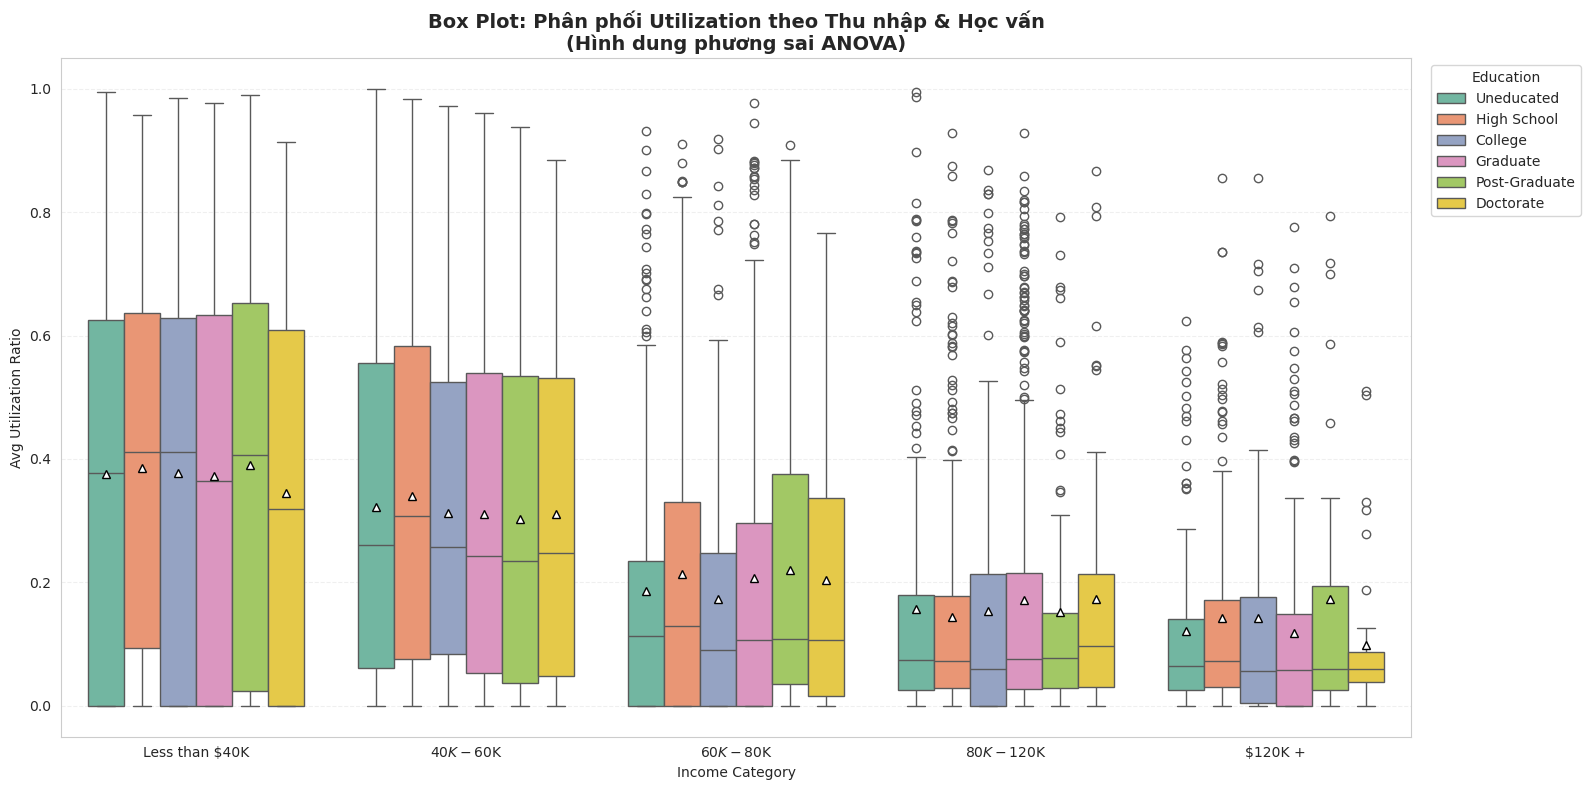

/tmp/ipykernel_1237/3311929793.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


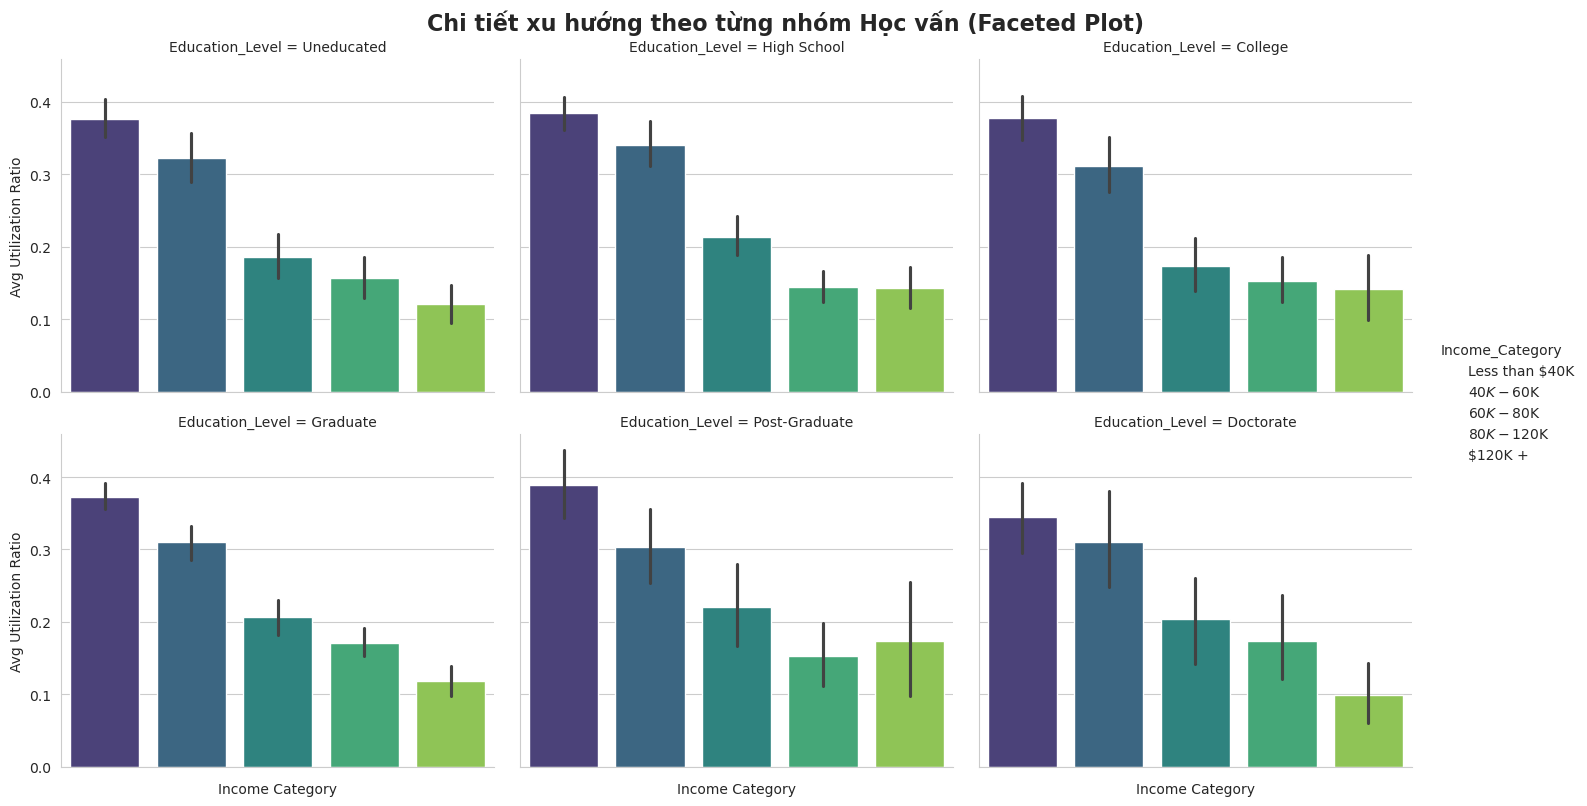

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_better_anova(df):
    # 1. ĐỊNH NGHĨA THỨ TỰ (Như cũ - rất quan trọng)
    income_order = [
        'Less than $40K', '$40K - $60K', '$60K - $80K', 
        '$80K - $120K', '$120K +', 'Unknown'
    ]
    edu_order = [
        'Uneducated', 'High School', 'College', 
        'Graduate', 'Post-Graduate', 'Doctorate', 'Unknown'
    ]
    
    # Lọc lại order
    income_order = [x for x in income_order if x in df['Income_Category'].unique()]
    edu_order = [x for x in edu_order if x in df['Education_Level'].unique()]

    # --- CÁCH 1: BOX PLOT (HIỂN THỊ PHÂN PHỐI & PHƯƠNG SAI) ---
    plt.figure(figsize=(16, 8))
    sns.boxplot(
        data=df,
        x='Income_Category',
        y='Avg_Utilization_Ratio',
        hue='Education_Level',
        order=income_order,
        hue_order=edu_order,
        palette='Set2', # Màu nhẹ nhàng hơn để dễ nhìn các hộp
        showmeans=True, # Hiển thị thêm dấu tam giác biểu thị giá trị Mean
        meanprops={"marker":"^", "markerfacecolor":"white", "markeredgecolor":"black"}
    )
    plt.title('Box Plot: Phân phối Utilization theo Thu nhập & Học vấn\n(Hình dung phương sai ANOVA)', fontsize=14, fontweight='bold')
    plt.xlabel('Income Category')
    plt.ylabel('Avg Utilization Ratio')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='Education')
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- CÁCH 2: FACET GRID (TÁCH NHỎ ĐỂ XEM XU HƯỚNG RÕ HƠN) ---
    # Dùng catplot để tạo lưới biểu đồ
    g = sns.catplot(
        data=df,
        x='Income_Category',
        y='Avg_Utilization_Ratio',
        col='Education_Level', # Tách mỗi Học vấn thành 1 biểu đồ riêng
        col_wrap=3,            # Mỗi hàng 3 biểu đồ
        kind='bar',            # Dùng Bar plot hoặc Point plot
        order=income_order,
        col_order=edu_order,
        palette='viridis',
        errorbar=('ci', 95),   # Hiển thị khoảng tin cậy
        height=4, 
        aspect=1.2
    )
    
    # Tinh chỉnh thẩm mỹ
    g.fig.suptitle('Chi tiết xu hướng theo từng nhóm Học vấn (Faceted Plot)', y=1.02, fontsize=16, fontweight='bold')
    g.set_xticklabels(rotation=45)
    g.set_axis_labels("Income Category", "Avg Utilization Ratio")
    
    plt.show()

# --- CHẠY THỬ ---
visualize_better_anova(df2)

- Kết quả trực tiếp:
    - Yếu tố Thu nhập: Có tác động cực kỳ mạnh mẽ. Nhóm khách hàng có thu nhập thấp (Less than $40K) có tỷ lệ sử dụng hạn mức cao nhất, thường dao động quanh mức 30-35%. Ngược lại, nhóm thu nhập cao nhất ($120K+) chỉ sử dụng khoảng 10-15% hạn mức.

    Lý do: Ngân hàng thường cấp hạn mức dựa trên thu nhập. Nhóm thu nhập thấp có hạn mức thấp (ví dụ: 20 triệu). Chỉ cần tiêu 10 triệu, tỷ lệ sử dụng đã là 50% trong khi đó, nhóm thu nhập cao có hạn mức rất lớn (ví dụ: 500 triệu). Dù họ tiêu gấp đôi nhóm kia (20 triệu), tỷ lệ sử dụng chỉ là 4%.
    - Yếu tố Học vấn: Kết quả ANOVA và biểu đồ cho thấy yếu tố này rất yếu hoặc không có ý nghĩa thống kê (P-value > 0.05). Trong cùng một mức thu nhập, một Tiến sĩ và một người không có bằng cấp có hành vi sử dụng hạn mức gần như tương đương nhau.
    Giả thuyết ban đầu: Giả thuyết "người có học vấn thấp vung tay quá trán" đã bị bác bỏ.
- Giải pháp thực tiễn:
    - Tập trung vào Thu nhập để phân khúc: Chiến lược Marketing và Quản trị rủi ro nên xoay quanh biến Income_Category.
    - Nhóm thu nhập thấp có Utilization cao: Rủi ro nợ xấu tiềm ẩn, nhưng cũng là nguồn thu lãi lớn.
    - Nhóm thu nhập cao có Utilization thấp: Rủi ro thấp, nhưng ít sinh lãi từ dư nợ quay vòng. Cần thúc đẩy họ bằng phí giao dịch qua các chương trình khuyến mãi.
- Bất ngờ:
Trình độ học vấn không phải là yếu tố dự báo tốt cho hành vi rủi ro tín dụng trong tập dữ liệu này. Điều này giúp ngân hàng đơn giản hóa mô hình chấm điểm tín dụng bằng cách giảm trọng số hoặc loại bỏ biến Education_Level.

#### **3. Có mối tương quan nào giữa tuổi khách hàng (Customer_Age) và thời gian sử dụng thẻ (Months_on_book) với tỷ lệ churn không?**

### A. Tiền xử lý

1. Kiểm tra và chuẩn hóa kiểu dữ liệu
- Mục đích: Đảm bảo `Customer_Age` và `Months_on_book` có kiểu số (numeric), `Attrition_Flag` được chuyển thành nhãn nhị phân `is_churn` (0/1) để tính toán và phân tích chính xác.

2. Kiểm tra và xử lý missing data
- Mục đích: Phát hiện các bản ghi thiếu giá trị ở các cột phân tích. Missing values có thể gây lỗi hoặc làm sai lệch kết quả thống kê, cần loại bỏ hoặc xử lý trước khi phân tích.

3. Kiểm tra và xử lý ngoại lai (outliers)
- Mục đích: Phát hiện các giá trị bất thường trong `Customer_Age` và `Months_on_book` bằng phương pháp IQR.

4. Phân nhóm tuổi và thời gian sử dụng thẻ
- Mục đích: Chia tuổi và thời gian sử dụng thẻ thành các nhóm rời rạc để so sánh tỷ lệ churn giữa các phân khúc khách hàng một cách trực quan và dễ hiểu hơn.

In [ ]:
# 1. Kiểm tra và chuẩn hóa kiểu dữ liệu
q3_cols = ['Customer_Age', 'Months_on_book', 'Attrition_Flag']
q3_df = df[q3_cols].copy()

# Đảm bảo Customer_Age và Months_on_book là kiểu số
q3_df['Customer_Age'] = pd.to_numeric(q3_df['Customer_Age'], errors='coerce')
q3_df['Months_on_book'] = pd.to_numeric(q3_df['Months_on_book'], errors='coerce')

# Chuẩn hóa nhãn churn thành nhị phân
q3_df['Attrition_Flag'] = q3_df['Attrition_Flag'].astype(str).str.strip()
q3_df['is_churn'] = q3_df['Attrition_Flag'].map({
    'Attrited Customer': 1,
    'Existing Customer': 0
})
if q3_df['is_churn'].isna().any():
    raise ValueError('Có giá trị Attrition_Flag không map được')
print("Kiểu dữ liệu sau chuẩn hóa:")
print(q3_df.dtypes)
print()

# 2. Kiểm tra và xử lý missing data
missing_before = q3_df[['Customer_Age', 'Months_on_book']].isna().sum()
print("Số missing values:")
print(missing_before)

# 3. Kiểm tra và xử lý ngoại lai (outliers)
def detect_outliers_iqr(series, col_name):
    """Phát hiện outliers bằng phương pháp IQR"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    print(f"{col_name}: Q1={Q1:.1f}, Q3={Q3:.1f}, IQR={IQR:.1f}")
    print(f"  Ngưỡng: [{lower_bound:.1f}, {upper_bound:.1f}]")
    print(f"  Số outliers: {len(outliers)} ({len(outliers)/len(series)*100:.2f}%)")
    return outliers

outliers_age = detect_outliers_iqr(q3_df['Customer_Age'], 'Customer_Age')
outliers_months = detect_outliers_iqr(q3_df['Months_on_book'], 'Months_on_book')
print("=> Không loại bỏ outliers vì giá trị tuổi và thời gian sử dụng thẻ đều hợp lý trong ngữ cảnh thực tế.")
print()

# 4. Phân nhóm tuổi và thời gian sử dụng thẻ

# Phân nhóm tuổi (khoảng 10 năm)
age_bins = [0, 30, 40, 50, 60, np.inf]
age_labels = ['<30', '30-39', '40-49', '50-59', '60+']
q3_df['age_group'] = pd.cut(q3_df['Customer_Age'], bins=age_bins, labels=age_labels, right=False)
print("Phân nhóm tuổi:")
print(q3_df['age_group'].value_counts().sort_index())
print()

# Phân nhóm thời gian sử dụng thẻ (theo năm)
months_bins = [0, 24, 36, 48, np.inf]
months_labels = ['<2 năm', '2-3 năm', '3-4 năm', '4+ năm']
q3_df['months_group'] = pd.cut(q3_df['Months_on_book'], bins=months_bins, labels=months_labels, right=False)
print("Phân nhóm thời gian sử dụng thẻ:")
print(q3_df['months_group'].value_counts().sort_index())
print()

### B. Phân tích

1. Tính tỷ lệ churn theo nhóm tuổi
- Thực hiện: Nhóm dữ liệu theo `age_group`, tính số khách hàng, số churn và tỷ lệ churn (%) cho từng nhóm.

2. Tính tỷ lệ churn theo thời gian sử dụng thẻ
- Thực hiện: Nhóm dữ liệu theo `months_group`, tính số khách hàng, số churn và tỷ lệ churn (%) cho từng nhóm thời gian.

3. Tính hệ số tương quan
- Thực hiện: Tính ma trận tương quan Pearson cho 3 biến và đánh giá độ mạnh của mối quan hệ.

4. Phân tích thống kê mô tả theo trạng thái churn
- Thực hiện: Tính mean, median, std của `Customer_Age` và `Months_on_book` cho từng nhóm `is_churn`.

In [ ]:
# 1. Tính tỷ lệ churn theo nhóm tuổi
print("1. TỶ LỆ CHURN THEO NHÓM TUỔI")
churn_by_age = (
    q3_df.groupby('age_group', observed=True)['is_churn']
    .agg(customers='size', churners='sum', churn_rate='mean')
    .reset_index()
)
churn_by_age['churn_rate'] = (churn_by_age['churn_rate'] * 100).round(2)
display(churn_by_age)
print("""Có thể thấy nhóm tuổi 40-49 có tỷ lệ churn cao nhất và đồng thời là nhóm có nhiều khách hàng nhất.
Nhóm tuổi dưới 30 có tỷ lệ churn thấp nhất, cho thấy khách hàng trẻ tuổi có xu hướng trung thành hơn 
tuy nhiên số lượng khách hàng trong nhóm này khá ít nên cần thận trọng khi đánh giá.
""")

# 2. Tính tỷ lệ churn theo thời gian sử dụng thẻ 
print("\n2. TỶ LỆ CHURN THEO THỜI GIAN SỬ DỤNG THẺ")
churn_by_months = (
    q3_df.groupby('months_group', observed=True)['is_churn']
    .agg(customers='size', churners='sum', churn_rate='mean')
    .reset_index()
)
churn_by_months['churn_rate'] = (churn_by_months['churn_rate'] * 100).round(2)
display(churn_by_months)
print("""Tỷ lệ churn gần như không thay đổi nhiều theo thời gian sử dụng thẻ. 
Tuy nhiên có xu hướng tăng nhẹ với các nhóm có năm sử dụng thẻ lâu hơn.
""")

In [ ]:
# 3. Tính hệ số tương quan 
print("3. HỆ SỐ TƯƠNG QUAN")
corr_cols = ['Customer_Age', 'Months_on_book', 'is_churn']
q3_corr = q3_df[corr_cols].corr()
display(q3_corr)
print("Customer_Age và Months_on_book có tương quan rất yếu với is_churn (r < 0.02)")
print("Hai biến này gần như không có khả năng dự báo churn")

# 4. Phân tích thống kê mô tả theo trạng thái churn 
print("\n4. THỐNG KÊ MÔ TẢ THEO TRẠNG THÁI CHURN")
q3_stats = q3_df.groupby('is_churn')[['Customer_Age', 'Months_on_book']].agg(['mean', 'median', 'std']).round(2)
q3_stats.index = q3_stats.index.map({0: 'Existing Customer', 1: 'Attrited Customer'})
display(q3_stats)
print("Tuổi trung bình và thời gian sử dụng thẻ của 2 nhóm gần như giống nhau")
print("Độ lệch chuẩn tương đương cho thấy phân bố của 2 nhóm không có sự khác biệt đáng kể")

### C. Trực quan hóa và Kết luận

In [ ]:
# Trực quan hóa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Tỷ lệ churn theo nhóm tuổi
ax1 = axes[0]
sns.barplot(data=churn_by_age, x='age_group', y='churn_rate', palette='Reds', ax=ax1, hue='age_group', legend=False)
ax1.set_title('Tỷ lệ churn theo nhóm tuổi')
ax1.set_xlabel('Nhóm tuổi')
ax1.set_ylabel('Tỷ lệ churn (%)')
ax1.bar_label(ax1.containers[0], fmt='%.1f%%', padding=3)

# 2. Tỷ lệ churn theo thời gian sử dụng thẻ
ax2 = axes[1]
sns.barplot(data=churn_by_months, x='months_group', y='churn_rate', palette='Blues', ax=ax2, hue='months_group', legend=False)
ax2.set_title('Tỷ lệ churn theo thời gian sử dụng thẻ')
ax2.set_xlabel('Thời gian sử dụng')
ax2.set_ylabel('Tỷ lệ churn (%)')
ax2.bar_label(ax2.containers[0], fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

#### **Kết luận Câu 3:**

**1. Trả lời câu hỏi được nêu lên ở câu 3:**

> *"Độ tuổi khách hàng và thời gian họ là chủ thẻ có mối liên hệ như thế nào với việc rời bỏ ngân hàng?"*

- **Customer_Age ↔ is_churn:** Hệ số tương quan = **0.018** → Tương quan **cực kỳ yếu**
- **Months_on_book ↔ is_churn:** Hệ số tương quan = **0.014** → Tương quan **cực kỳ yếu**
- **Kết luận:** **Tuổi và thời gian sử dụng thẻ KHÔNG có mối liên hệ đáng kể với việc churn.** Các yếu tố nhân khẩu học này không phải là chỉ báo quan trọng để dự đoán khách hàng rời bỏ ngân hàng.

**2. Giải pháp thực tiễn:**

- **Chuyển hướng phân tích:** Ngân hàng nên tập trung vào các **yếu tố hành vi giao dịch** (Total_Revolving_Bal, Total_Trans_Amt, Total_Trans_Ct) thay vì nhân khẩu học để nhận diện khách hàng có nguy cơ rời bỏ.
- **Phân khúc khách hàng:** Dù tương quan yếu, nhóm **40-59 tuổi** vẫn có tỷ lệ churn cao nhất (~17%), có thể kết hợp với các tiêu chí khác để tạo mô hình cảnh báo sớm.
- **Chương trình giữ chân:** Thiết kế các chương trình loyalty đặc biệt cho khách hàng lâu năm (4+ năm) để giảm xu hướng churn tăng nhẹ theo thời gian.

**3. Phát hiện bất ngờ:**

- **Customer_Age và Months_on_book có tương quan rất mạnh với nhau (r = 0.789)**, nhưng cả hai đều gần như không liên quan đến churn.
- **Giải thích:** Điều này cho thấy churn là quyết định phụ thuộc vào **trải nghiệm dịch vụ và hành vi sử dụng sản phẩm**, không phải đặc điểm cố định của khách hàng. Một khách hàng trẻ hay lớn tuổi, mới hay lâu năm đều có thể rời bỏ nếu không hài lòng với dịch vụ - đây là tin tốt vì ngân hàng có thể **chủ động cải thiện** để giữ chân khách hàng ở mọi phân khúc.

#### **4. Liệu những khách hàng sở hữu hạn mức tín dụng cao (Credit Limit cao) nhưng lại để thẻ 'đóng băng' mới là nhóm đang âm thầm rời bỏ ngân hàng nhiều nhất hay không?**

### A. Tiền xử lý

1. Kiểm tra và chuẩn hóa kiểu dữ liệu
- Mục đích: Đảm bảo `Credit_Limit` và `Avg_Utilization_Ratio` có kiểu số (numeric), `Attrition_Flag` được chuyển thành nhãn nhị phân `is_churn` (0/1) để tính toán và phân tích chính xác.

2. Kiểm tra và xử lý missing data
- Mục đích: Loại bỏ các bản ghi thiếu giá trị ở `Credit_Limit` hoặc `Avg_Utilization_Ratio` để đảm bảo kết quả thống kê nhất quán.

3. Phân nhóm hạn mức và mức sử dụng theo tứ phân vị
- Mục đích: Chia `Credit_Limit` và `Avg_Utilization_Ratio` thành 4 nhóm (quartiles) để so sánh công bằng giữa các phân khúc khách hàng với quy mô tương đương.

4. Tạo chỉ báo nhóm "đóng băng" (`is_highlimit_lowutil`)
- Mục đích: Đánh dấu nhóm khách hàng có hạn mức cao nhưng sử dụng thấp để kiểm tra trực tiếp giả thuyết về nhóm "đóng băng" thẻ.

In [ ]:
# 1. KIỂM TRA VÀ CHUẨN HÓA KIỂU DỮ LIỆU
credit_cols = ['Attrition_Flag', 'Credit_Limit', 'Avg_Utilization_Ratio']
credit_df = df[credit_cols].copy()

# Đảm bảo Credit_Limit và Avg_Utilization_Ratio là kiểu số
credit_df['Credit_Limit'] = pd.to_numeric(credit_df['Credit_Limit'], errors='coerce')
credit_df['Avg_Utilization_Ratio'] = pd.to_numeric(credit_df['Avg_Utilization_Ratio'], errors='coerce')

# Chuẩn hóa nhãn churn thành nhị phân
credit_df['Attrition_Flag'] = credit_df['Attrition_Flag'].astype(str).str.strip()
credit_df['is_churn'] = credit_df['Attrition_Flag'].map({
    'Attrited Customer': 1,
    'Existing Customer': 0
})
if credit_df['is_churn'].isna().any():
    raise ValueError('Có giá trị Attrition_Flag không map được')
print("Kiểu dữ liệu sau chuẩn hóa:")
print(credit_df.dtypes)
print()

# 2. KIỂM TRA VÀ XỬ LÝ MISSING DATA
missing_before = credit_df[['Credit_Limit', 'Avg_Utilization_Ratio']].isna().sum()
print("Số missing values trước xử lý:")
print(missing_before)
credit_df = credit_df.dropna(subset=['Credit_Limit', 'Avg_Utilization_Ratio'])
print(f"Số dòng còn lại sau khi loại missing: {len(credit_df)}")
print()

# 3. PHÂN NHÓM HẠN MỨC VÀ MỨC SỬ DỤNG THEO TỨ PHÂN VỊ
limit_labels = ['Limit thấp', 'Limit trung bình thấp', 'Limit trung bình cao', 'Limit cao']
util_labels = ['Sử dụng rất thấp', 'Sử dụng thấp', 'Sử dụng trung bình', 'Sử dụng cao']

credit_df['limit_band'] = pd.qcut(credit_df['Credit_Limit'], q=4, labels=limit_labels)
credit_df['util_band'] = pd.qcut(credit_df['Avg_Utilization_Ratio'], q=4, labels=util_labels)

print("Phân nhóm hạn mức tín dụng:")
print(credit_df['limit_band'].value_counts().sort_index())
print()
print("Phân nhóm mức sử dụng thẻ:")
print(credit_df['util_band'].value_counts().sort_index())
print()

# 4. TẠO CHỈ BÁO NHÓM "ĐÓNG BĂNG" 
credit_df['is_highlimit_lowutil'] = (
    (credit_df['limit_band'] == 'Limit cao')
    & (credit_df['util_band'].isin(['Sử dụng rất thấp', 'Sử dụng thấp']))
)
print(f"Số khách hàng nhóm 'Limit cao & Sử dụng thấp': {credit_df['is_highlimit_lowutil'].sum()}")
print(f"Tỷ lệ: {credit_df['is_highlimit_lowutil'].mean()*100:.2f}%")

credit_df.head()

### B. Phân tích

1. Tính tỷ lệ churn theo tổ hợp hạn mức - mức sử dụng
- Thực hiện: Nhóm dữ liệu theo `limit_band` × `util_band`, tính số khách hàng, số churn và tỷ lệ churn (%) cho từng tổ hợp.

2. So sánh nhóm "Limit cao & Sử dụng thấp" với phần còn lại
- Thực hiện: Tính tỷ lệ churn riêng cho nhóm `is_highlimit_lowutil=True` và so sánh với nhóm còn lại để kiểm tra giả thuyết.

3. Nhận diện phân khúc rủi ro cao
- Thực hiện: Xác định các tổ hợp có tỷ lệ churn vượt ngưỡng cảnh báo (>30%) để ưu tiên hành động giữ chân.

In [ ]:
# 1. TỶ LỆ CHURN THEO TỔ HỢP HẠN MỨC - MỨC SỬ DỤNG
print("1. TỶ LỆ CHURN THEO TỔ HỢP HẠN MỨC - MỨC SỬ DỤNG")
segment_summary = (
    credit_df.groupby(['limit_band', 'util_band'], observed=True)['is_churn']
    .agg(customers='size', churners='sum', churn_rate='mean')
    .reset_index()
)
segment_summary['churn_rate'] = (segment_summary['churn_rate'] * 100).round(2)
display(segment_summary.sort_values(['limit_band', 'util_band']))
print("Nhận xét: " \
"Nhóm có hạn mức thấp nhưng sử dụng thấp có tỷ lệ churn cao nhất")
print("Nhóm có hạn mức trung bình thấp nhưng sử dụng trung bình có tỷ lệ churn thấp nhất")

# 2. SO SÁNH NHÓM "LIMIT CAO & SỬ DỤNG THẤP" VỚI PHẦN CÒN LẠI 
print("\n2. SO SÁNH NHÓM 'LIMIT CAO & SỬ DỤNG THẤP' VỚI PHẦN CÒN LẠI")
hl_stats = (
    credit_df.groupby('is_highlimit_lowutil', observed=True)['is_churn']
    .agg(customers='size', churners='sum', churn_rate='mean')
    .reset_index()
)
hl_stats['label'] = hl_stats['is_highlimit_lowutil'].map({
    True: 'Limit cao & Sử dụng thấp',
    False: 'Nhóm còn lại'
})
hl_stats['churn_rate'] = (hl_stats['churn_rate'] * 100).round(2)
display(hl_stats[['label', 'customers', 'churners', 'churn_rate']])
print("Nhóm 'Limit cao & Sử dụng thấp' có tỷ lệ churn thấp hơn nhẹ so với nhóm còn lại")
print("Điều này có vẻ đi ngược với suy nghĩ ban đầu của chúng ta")

# 3. NHẬN DIỆN PHÂN KHÚC RỦI RO CAO
print("\n3. PHÂN KHÚC RỦI RO CAO (Churn > 30%)")
risk_segments = segment_summary[segment_summary['churn_rate'] > 30].sort_values('churn_rate', ascending=False)
display(risk_segments)
print("Các phân khúc rủi ro cao cần được ưu tiên trong chiến lược giữ chân khách hàng")

### C. Trực quan hóa

In [ ]:
# Heatmap hiển thị churn rate theo tổ hợp hạn mức - sử dụng
heat_data = segment_summary.pivot(
    index='limit_band', columns='util_band', values='churn_rate'
)
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(
    heat_data,
    annot=True,
    fmt='.1f',
    cmap='Reds',
    cbar_kws={'label': 'Tỷ lệ churn (%)'},
    ax=ax
 )
ax.set_xlabel('Nhóm mức sử dụng thẻ')
ax.set_ylabel('Nhóm hạn mức tín dụng')
ax.set_title('Tỷ lệ churn (%) theo hạn mức và mức sử dụng')
plt.tight_layout()
plt.show()

In [ ]:
# Biểu đồ cột so sánh nhóm high-limit/low-util với các nhóm khác
hl_stats = (
    credit_df.groupby('is_highlimit_lowutil', observed=True)['is_churn']
    .agg(customers='size', churners='sum', churn_rate='mean')
    .reset_index()
 )
hl_stats['label'] = hl_stats['is_highlimit_lowutil'].map({
    True: 'Limit cao & sử dụng thấp',
    False: 'Nhóm còn lại'
})
hl_stats['churn_rate'] = (hl_stats['churn_rate'] * 100).round(2)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(
    data=hl_stats,
    x='label',
    y='churn_rate',
    hue='label',
    ax=ax,
    palette=['#72B7B2', '#E4572E']
 )
ax.set_ylabel('Tỷ lệ churn (%)')
ax.set_xlabel('Nhóm khách hàng')
ax.set_title('So sánh tỷ lệ churn của nhóm high-limit/low-util')
ax.bar_label(ax.containers[0], fmt='%.1f%%', padding=3)
plt.tight_layout()
plt.show()

hl_stats

#### **Kết luận Câu 4:**

**1. Trả lời câu hỏi được nêu lên ở đầu:**

> *"Liệu những khách hàng sở hữu hạn mức tín dụng cao nhưng lại để thẻ 'đóng băng' mới là nhóm đang âm thầm rời bỏ ngân hàng nhiều nhất hay không?"*

- **Kết luận:** **KHÔNG.** Giả thuyết bị bác bỏ. Nhóm khách hàng hạn mức cao nhưng "đóng băng" thẻ **KHÔNG** phải là nhóm rời bỏ nhiều nhất. Thực tế, nhóm này có tỷ lệ churn **thấp hơn** so với phần còn lại.
- **Nhóm "Limit cao & Sử dụng thấp":** Tỷ lệ churn = **14.5%**
- **Nhóm còn lại:** Tỷ lệ churn = **16.6%**

**2. Giải pháp thực tiễn:**

- **Ưu tiên nhóm hạn mức thấp + sử dụng rất thấp:** Đây mới là nhóm có tỷ lệ churn cao nhất (39-100%), cần chiến dịch tái kích hoạt khẩn cấp.
- **Nhóm hạn mức cao + sử dụng thấp:** Rủi ro churn thấp, nên tập trung **ưu đãi kích hoạt** (cashback, điểm thưởng) thay vì cảnh báo churn.
- **Chiến lược chung:** Tăng mức sử dụng thẻ là chìa khóa giảm churn - bất kể hạn mức, churn giảm rõ rệt khi khách hàng sử dụng thẻ nhiều hơn.

**3. Phát hiện bất ngờ:**

- **Churn cao nhất ở nhóm hạn mức THẤP, không phải hạn mức CAO** - ngược với trực giác ban đầu.
- **Giải thích:** Khách hàng được cấp hạn mức thấp có thể cảm thấy không được ngân hàng đánh giá cao, hoặc thẻ không đáp ứng nhu cầu chi tiêu của họ. Khi họ "đóng băng" thẻ (sử dụng rất thấp), đó là tín hiệu mạnh cho thấy họ đã chuyển sang sản phẩm khác và chuẩn bị rời bỏ. Ngược lại, khách hạn mức cao có thể đã có mối quan hệ tốt với ngân hàng nên dù không dùng nhiều, họ vẫn giữ thẻ như 1 sự dự phòng.

#### **5. Các hành vi giao dịch trong 12 tháng gần nhất có thể dự báo churn không? Các biến đổi trong hành vi giao dịch (`Months_Inactive_12_mon`, `Contacts_Count_12_mon`, `Total_Trans_Amt`, `Total_Trans_Ct`) có liên quan mạnh tới việc khách bỏ đi không?**

### A. Tiền xử lý (Preprocessing)

1. Kiểm tra và chuẩn hóa kiểu dữ liệu
- Mục đích: Đảm bảo 4 biến hành vi (`Months_Inactive_12_mon`, `Contacts_Count_12_mon`, `Total_Trans_Amt`, `Total_Trans_Ct`) có kiểu số (numeric), `Attrition_Flag` được chuyển thành nhãn nhị phân `is_churn` (0/1).

2. Kiểm tra và xử lý missing data
- Mục đích: Loại bỏ các bản ghi thiếu giá trị ở các biến hành vi để đảm bảo thống kê và đánh giá mô hình nhất quán.

3. Xác định các biến hành vi cần phân tích
- Mục đích: Tách riêng 4 biến hành vi giao dịch (`behavior_features`) để phục vụ phân tích tương quan, so sánh phân phối và xây dựng mô hình dự báo.

In [ ]:
# 1. KIỂM TRA VÀ CHUẨN HÓA KIỂU DỮ LIỆU
behavior_cols = [
    'Attrition_Flag',
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon',
    'Total_Trans_Amt',
    'Total_Trans_Ct',
]
behavior_df = df[behavior_cols].copy()

# Đảm bảo các biến hành vi là kiểu số
for col in ['Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Trans_Amt', 'Total_Trans_Ct']:
    behavior_df[col] = pd.to_numeric(behavior_df[col], errors='coerce')

# Chuẩn hóa nhãn churn thành nhị phân
behavior_df['Attrition_Flag'] = behavior_df['Attrition_Flag'].astype(str).str.strip()
behavior_df['is_churn'] = behavior_df['Attrition_Flag'].map({
    'Attrited Customer': 1,
    'Existing Customer': 0,
})
if behavior_df['is_churn'].isna().any():
    raise ValueError('Có giá trị Attrition_Flag không map được sang is_churn')
print("Kiểu dữ liệu sau chuẩn hóa:")
print(behavior_df.dtypes)
print()

# 2. KIỂM TRA VÀ XỬ LÝ MISSING DATA
missing_before = behavior_df[['Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Trans_Amt', 'Total_Trans_Ct']].isna().sum()
print("Số missing values trước xử lý:")
print(missing_before)
behavior_df = behavior_df.dropna()
print(f"Số dòng còn lại sau khi loại missing: {len(behavior_df)}")
print()

# 3. XÁC ĐỊNH CÁC BIẾN HÀNH VI CẦN PHÂN TÍCH
behavior_features = [
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon',
    'Total_Trans_Amt',
    'Total_Trans_Ct',
]
print("Các biến hành vi cần phân tích:")
print(behavior_features)

behavior_df[behavior_features + ['is_churn']].head()

### B. Phân tích

1. So sánh thống kê mô tả giữa nhóm churn và non-churn
- Thực hiện: Tính mean, median, std của 4 biến hành vi cho từng nhóm `is_churn` để phát hiện sự khác biệt.

2. Phân tích tỷ lệ churn theo tứ phân vị của từng biến
- Thực hiện: Chia mỗi biến thành 4 nhóm (quartiles), tính tỷ lệ churn cho từng nhóm để xác định ngưỡng rủi ro.

3. Tính ma trận tương quan
- Thực hiện: Tính hệ số tương quan Pearson giữa 4 biến hành vi và `is_churn` để đánh giá mức độ liên quan tuyến tính.

In [ ]:
# 1. SO SÁNH THỐNG KÊ MÔ TẢ GIỮA NHÓM CHURN VÀ GIỮ CHÂN
print("1. THỐNG KÊ MÔ TẢ THEO TRẠNG THÁI CHURN")
summary_stats = (
    behavior_df.groupby('is_churn', observed=True)[behavior_features]
    .agg(['mean', 'median', 'std'])
    .round(2)
)
summary_stats.index = summary_stats.index.map({0: 'Existing Customer', 1: 'Attrited Customer'})
display(summary_stats)
print("Nhận xét: Khách hàng rời đi (Attrited Customer) có số tháng không hoạt động và số lần liên hệ cao hơn")
print("Ngược lại, tổng số giao dịch (Trans_Ct) và tổng giá trị giao dịch (Trans_Amt) thấp hơn đáng kể")

In [ ]:
# Phân phối các biến hành vi theo trạng thái churn
plot_df = behavior_df.assign(
    churn_label=behavior_df['is_churn'].map({0: 'Existing', 1: 'Attrited'})
)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, col in zip(axes.flat, behavior_features):
    sns.kdeplot(
        data=plot_df,
        x=col,
        hue='churn_label',
        hue_order=['Existing', 'Attrited'],
        fill=True,
        alpha=0.35,
        common_norm=False,
        linewidth=1.2,
        ax=ax,
    )

    ax.set_title(f'Phân phối {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Mật độ')

    leg = ax.get_legend()
    if leg:
        leg.set_title('Trạng thái churn')

plt.tight_layout()
plt.show()

In [ ]:
# 2. TỶ LỆ CHURN THEO TỨ PHÂN VỊ CỦA TỪNG BIẾN
print("2. TỶ LỆ CHURN THEO TỨ PHÂN VỊ CỦA TỪNG BIẾN HÀNH VI")
bin_frames = []
for col in behavior_features:
    bins = pd.qcut(behavior_df[col], q=4, duplicates='drop')
    temp = (
        behavior_df.assign(bin=bins)
        .groupby('bin', observed=True)['is_churn']
        .agg(customers='size', churners='sum', churn_rate='mean')
        .reset_index()
    )
    temp['feature'] = col
    temp['bin'] = temp['bin'].astype(str)
    temp['churn_rate'] = (temp['churn_rate'] * 100).round(2)
    bin_frames.append(temp[['feature', 'bin', 'customers', 'churners', 'churn_rate']])
quantile_summary = pd.concat(bin_frames, ignore_index=True)
display(quantile_summary)

Nhận xét: 

- Khách hàng không hoạt động 3+ tháng có tỷ lệ churn cao nhất.
- Khách hàng liên hệ ngân hàng nhiều (3 đến 6 lần) cũng có nguy cơ churn cao.
- Khách hàng tổng lượng giao dịch thấp sẽ có nguy cơ churn cao.
- Nhóm có Total_Trans_Ct thấp nhất (Q1) có tỷ lệ churn rất cao.

In [ ]:
# 3. MA TRẬN TƯƠNG QUAN
print("3. MA TRẬN TƯƠNG QUAN GIỮA HÀNH VI GIAO DỊCH VÀ CHURN")
corr_matrix = behavior_df[behavior_features + ['is_churn']].corr()
print("\nHệ số tương quan với is_churn:")
print(corr_matrix['is_churn'].drop('is_churn').sort_values(key=lambda x: x.abs(), ascending=False).round(3))

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
ax.set_title('Ma trận tương quan giữa hành vi giao dịch và churn')
plt.tight_layout()
plt.show()

Nhận xét: 
- Total_Trans_Ct có tương quan âm mạnh nhất với churn - càng giao dịch nhiều càng ít rời đi
- Contacts_Count_12_mon và Months_Inactive_12_mon có tương quan dương - tín hiệu cảnh báo sớm

### C. Triển khai mô hình và đánh giá
- Chạy mô hình dự báo dựa trên bốn biến hành vi để kiểm tra khả năng phân biệt churn và trích xuất insight phục vụ hành động.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

Chuẩn bị data và huấn luyện với 2 mô hình logistic và random forest

In [ ]:
# Chuẩn bị dữ liệu huấn luyện mô hình 
behavior_X = behavior_df[behavior_features]
behavior_y = behavior_df['is_churn']

#Chia tập huấn luyện và kiểm tra
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    behavior_X, behavior_y, test_size=0.3, random_state=42, stratify=behavior_y
 )

# Định nghĩa các pipeline mô hình
behavior_pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=500, class_weight='balanced')),
    ]),
    'Random Forest': Pipeline([
        ('model', RandomForestClassifier(
            n_estimators=400,
            max_depth=8,
            random_state=42,
            class_weight='balanced'
        ))
    ]),
}

# Huấn luyện và đánh giá mô hình
behavior_results = []
behavior_conf_matrices = {}
behavior_y_scores = {}
behavior_models = {}

for name, model in behavior_pipelines.items():
    model.fit(Xb_train, yb_train)
    yb_pred = model.predict(Xb_test)
    yb_proba = model.predict_proba(Xb_test)[:, 1]
    acc = accuracy_score(yb_test, yb_pred)
    auc = roc_auc_score(yb_test, yb_proba)
    behavior_conf_matrices[name] = confusion_matrix(yb_test, yb_pred)
    behavior_y_scores[name] = yb_proba
    behavior_models[name] = model
    behavior_results.append({
        'Model': name,
        'Accuracy': round(acc, 3),
        'ROC_AUC': round(auc, 3),
    })

pd.DataFrame(behavior_results)

Nhận xét: 
- Cả 2 mô hình đều có độ chính xác >0.75 cho thấy khả năng dự báo tốt. Đặc biệt là Random Forest.
- Chỉ số ROC_AUC cao >0.85 cho thấy khả năng phân biệt tốt giữa 2 lớp churn và không churn mặc dù biến mục tiêu bị mất cân bằng.

#### Confusion matrix

In [ ]:
# Ma trận nhầm lẫn cho từng mô hình hành vi
fig, axes = plt.subplots(1, len(behavior_conf_matrices), figsize=(10, 4))
if len(behavior_conf_matrices) == 1:
    axes = [axes]
for ax, (name, cm) in zip(axes, behavior_conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Ma trận nhầm lẫn - {name}')
    ax.set_xlabel('Dự đoán')
    ax.set_ylabel('Thực tế')
plt.tight_layout()
plt.show()

Nhận xét: 
- Mô hình dự đoán khá tốt nhóm Existing Customer (True Negative cao)
- Tuy nhiên, tỷ lệ False Negative cần được cải thiện để giảm bỏ sót khách hàng có nguy cơ churn.

In [ ]:
# Đường ROC so sánh hai mô hình
fig, ax = plt.subplots(figsize=(6, 6))
for name, y_score in behavior_y_scores.items():
    fpr, tpr, _ = roc_curve(yb_test, y_score)
    ax.plot(fpr, tpr, label=name)
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ngẫu nhiên')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Hành vi giao dịch')
ax.legend()
plt.tight_layout()
plt.show()

Nhận xét: 
- Đường cong ROC của cả 2 mô hình đều nằm nằm sát góc trái phía trên và xa đường ngẫu nhiên.
- Điều này xác nhận các biến hành vi giao dịch có khả năng dự báo churn tốt.
- Random Forest có khả năng dự đoán tốt hơn Logistic Regression.

In [ ]:
# Hệ số logistic và độ quan trọng random forest
fig, axes = plt.subplots(1, len(behavior_models), figsize=(6 * len(behavior_models), 4))
if len(behavior_models) == 1:
    axes = [axes]
for ax, (name, model) in zip(axes, behavior_models.items()):
    if name == 'Logistic Regression':
        coef_df = pd.DataFrame({
            'Feature': behavior_features,
            'Coefficient': model.named_steps['model'].coef_[0],
        }).sort_values('Coefficient', key=lambda s: s.abs(), ascending=False)
        sns.barplot(data=coef_df, x='Coefficient', y='Feature', hue='Feature', palette='Blues_r', ax=ax)
        ax.axvline(0, color='black', linewidth=1)
        ax.set_title('Hệ số chuẩn hóa - Logistic Regression')
    elif name == 'Random Forest':
        imp_df = pd.DataFrame({
            'Feature': behavior_features,
            'Importance': model.named_steps['model'].feature_importances_,
        }).sort_values('Importance', ascending=True)
        sns.barplot(data=imp_df, x='Importance', y='Feature', hue='Feature', palette='Reds', ax=ax)
        ax.set_title('Độ quan trọng - Random Forest')
plt.tight_layout()
plt.show()

Nhận xét: 
- Total_Trans_Ct là biến quan trọng nhất trong cả 2 mô hình
- Hệ số âm của Total_Trans_Ct trong Logistic cho thấy giao dịch nhiều → giảm churn

In [ ]:
# Chọn ra tứ phân vị có churn cao nhất của từng biến hành vi
risk_highlights = (
    quantile_summary
    .sort_values('churn_rate', ascending=False)
    .groupby('feature', as_index=False)
    .first()
    .sort_values('churn_rate', ascending=False)
    .reset_index(drop=True)
 )
risk_highlights

Nhận xét: 
- Đây là các phân khúc cần ưu tiên can thiệp trong chiến lược giữ chân khách hàng
- Khách hàng có Total_Trans_Ct thấp nhất là nhóm có nguy cơ churn cao nhất

#### **Kết luận Câu 5:**

**1. Trả lời câu hỏi được nêu lên ở câu 5:**

> *"Các hành vi giao dịch trong 12 tháng gần nhất có thể dự báo churn không? Các biến Months_Inactive_12_mon, Contacts_Count_12_mon, Total_Trans_Amt, Total_Trans_Ct có liên quan mạnh tới việc khách bỏ đi không?"*

- **Kết luận:** **CÓ.** Các biến hành vi giao dịch có khả năng dự báo churn tốt. Mô hình Random Forest đạt **ROC AUC = 0.95**, Logistic Regression đạt **ROC AUC = 0.86**, cho thấy hành vi giao dịch là chỉ báo mạnh để nhận diện khách hàng có nguy cơ rời bỏ.
- Trong đó **Total_Trans_Ct ↔ is_churn:** là feature có tác động lớn nhất. Hệ số tương quan = **-0.37**.

**2. Giải pháp thực tiễn:**

- **Thiết lập cảnh báo sớm:** Khi khách hàng rơi vào tứ phân vị thấp nhất của `Total_Trans_Amt`/`Total_Trans_Ct` (churn >35%) hoặc tứ phân vị cao nhất của `Months_Inactive_12_mon`, cần kích hoạt chiến dịch giữ chân ngay.
- **Ưu tiên khách liên hệ nhiều nhưng giảm giao dịch:** Nhóm này đang có vấn đề và tìm cách giải quyết - cần gọi lại để tháo gỡ vướng mắc trước khi họ rời bỏ.
- **Tích hợp mô hình vào thực tiễn:** Sử dụng Random Forest để scoring khách hàng hàng tháng, ưu tiên can thiệp nhóm có xác suất churn cao.

**3. Phát hiện bất ngờ:**

- **`Total_Trans_Ct` (số lần giao dịch) quan trọng hơn `Total_Trans_Amt` (tổng giá trị giao dịch)** trong việc dự báo churn - khách hàng quẹt thẻ thường xuyên, dù mỗi lần ít tiền, vẫn trung thành hơn khách hàng quẹt ít lần dù giá trị lớn.
- **Giải thích:** Tần suất sử dụng phản ánh mức độ gắn bó với sản phẩm. Khách hàng dùng thẻ hàng ngày cho chi tiêu nhỏ (cà phê, siêu thị) đã hình thành **thói quen** và khó bỏ thẻ hơn so với khách chỉ dùng cho giao dịch lớn định kỳ. Ngân hàng nên khuyến khích sử dụng thẻ cho chi tiêu hàng ngày thay vì chỉ tập trung vào giao dịch giá trị cao.

## VI. Project Summary

### Key Findings
- Trong việc phân tích dữ liệu cần đặt những câu hỏi thực tế và mang lại lợi ích cho doanh nghiệp. 
- Nhóm tuổi 40–59 (đặc biệt 55–59) có số lượng khách và tỷ lệ churn cao.
- Khách hạn mức cao nhưng ít sử dụng không phải nguồn churn chính; trọng tâm giữ chân nên đặt vào nhóm hạn mức thấp và giảm giao dịch.
- Mô hình Random Forest đạt hiệu suất cao hơn hẳn Logistic Regression trên khả năng dự đoán rời bỏ của khách hàng dựa vào hành vi giao dịch. 

### Limitations
- Dữ liệu dạng ảnh chụp 12 tháng, chưa theo dõi động thái thời gian thực nên khó bắt chuỗi sự kiện dẫn tới churn.
- Thiếu biến về kênh tương tác, chất lượng dịch vụ, nhân khẩu học chi tiết; hạn chế khả năng giải thích nguyên nhân.
- Mô hình hiện chủ yếu dùng các biến giao dịch; cần thêm đặc trưng tín dụng và hành vi đa kênh để tăng độ chính xác.
- Chưa có thử nghiệm A/B cho các biện pháp can thiệp, nên chưa xác nhận hiệu quả ngoài thực tế.

### Future Directions 
- Mở rộng câu hỏi: churn theo chuỗi thời gian, tác động của chiến dịch CSKH và ưu đãi tái kích hoạt.
- Phân tích sâu: mô hình cảnh báo sớm theo thời điểm, phân đoạn hành vi theo kênh số.
- Phương pháp thay thế: thử Gradient Boosting/XGBoost, so sánh với mô hình tuyến tính để cân bằng hiệu năng–giải thích.
- Bổ sung dữ liệu: thêm log liên hệ CSKH, lịch sử ưu đãi, thông tin nhân khẩu học và sản phẩm đi kèm.
- Triển khai: tích hợp vào CRM, thiết lập trigger dựa trên ngưỡng giao dịch/không hoạt động, chạy thử nghiệm A/B và đo lường KPI giữ chân.

### Individual Reflections

#### **Châu Văn Minh Khoa - 23122035**

Dự án phân tích churn khách hàng ngân hàng giúp em hiểu quy trình Data Science hoàn chỉnh từ EDA đến xây dựng mô hình. Em đã tham gia tiền xử lý dữ liệu, phân tích tương quan, và đặc biệt là phần phân tích hành vi giao dịch (Câu 5).

- Tiền xử lý dữ liệu kỹ lưỡng quan trọng hơn việc chọn thuật toán phức tạp.
- Các biến nhân khẩu học (tuổi, thời gian sử dụng thẻ) có tương quan yếu với churn, trong khi biến hành vi giao dịch mới thực sự dự báo được.
- `Total_Trans_Ct` quan trọng hơn `Total_Trans_Amt` - khách hàng gắn bó qua thói quen sử dụng, không phải giá trị giao dịch.

Dự án giúp em rèn luyện tư duy phân tích và giải quyết vấn đề kinh doanh thực tế. Data Science không chỉ là viết code, mà quan trọng là khả năng đặt câu hỏi đúng và thấu hiểu trong mỗi lĩnh vực.

#### **Phan Ngọc Quân - 23122046**

Dự án phân tích churn khách hàng ngân hàng giúp em hiểu và nắm rõ hơn quy trình Data Science hoàn chỉnh từ EDA đến xây dựng mô hình. Đây là những gì em rút ra được:

- Quá trình EDA không hề dễ dàng chút nào, tuy không đụng gì đến các mô hình nhưng việc phải hiểu và làm quen với bộ Dataset mình mới tiếp xúc thật sự là khó khăn
- Việc đặt ra các câu Insight Questions là phần quan trọng và cần tìm hiểu kĩ nhất, câu hỏi càng hay thì càng chứng tỏ mình hiểu Dataset
- Có thêm hiểu biết về lĩnh vực ngân hàng, biết được những biến nào ảnh hưởng đến tỉ lệ rời đi của khách hàng .

Dự án giúp em rèn luyện tư duy phân tích và áp dụng các kiến thức của Data Science vào lĩnh vực kinh doanh thực tế.